# Walkthough of Vamb from the Python interpreter

The Vamb pipeline consist of a series of tasks each which have a dedicated module:

1) Parse fasta file and get TNF of each sequence, as well as sequence length and names (module `parsecontigs`)

2) Parse the BAM files and get abundance estimate for each sequence in the fasta file (module `parsebam`)

3) Train a VAE with the abundance and TNF matrices, and encode it to a latent representation (module `encode`)

4) Cluster the encoded inputs to metagenomic bins (module `cluster`)

Additionally, for developing and testing Vamb, we use:

5) Benchmark the resulting bins against a gold standard (module `benchmark`)

In the following chapters of this walkthrough, we will go through each step in more detail from within the Python interpreter. We will show how to use Vamb by example, what each step does, some of the theory behind the actions, and the different parameters that can be set. With this knowledge, you should be able to extend or alter the behaviour of Vamb more easily.

For the examples, we will assume the following relevant prerequisite files exists in the directory `/Users/jakobnissen/Downloads/example/`:

* `contigs.fna.gz` - The filtered FASTA contigs which were mapped against, and
* `bam/*.bam` - 9 BAM files from the mapping.

## Table of contents:

### 1. [Introduction to metagenomic binning and best practices](#introduction)

### 2. [Importing Vamb and getting help](#importing)

### 3. [Calculate the sequence tetranucleotide frequencies](#parsecontigs)

### 4. [Calculate the abundance matrix](#parsebam)

### 5. [Train the autoencoder and encode input data](#encode)

### 6. [Binning the encoding](#cluster)

### 7. [Postprocessing the bins](#postprocessing)

### 8. [Summary of full workflow](#summary)

### 9. [Running VAMB with low memory (RAM)](#memory)

### 10. [Optional: Benchmarking your bins](#benchmark)

<a id="introduction"></a>
## Introduction to metagenomic binning and best practices

When we began working on the Vamb project, we had been doing reference-free metagenomics for years using MetaBAT2, and thought we had a pretty good idea of how metagenomic binning worked and what to watch out for. Turns out, there's more to it than we had thought about. During this project, our group have revised the way we use binners multiple times as we've learned the dos and don'ts. In this introduction I will cover some facts of binning that is useful for the end user.

__1. Binning is a hard problem__

Various binning papers (including ours), typically brag about how many high-quality genomes they've been able to reconstruct from data. However, examining the actual number of genomes reconstructed compared to the estimated diversity of the samples can be sobering: Only a very small fraction of the organisms are binned decently. In fact, only a small fraction of the *sequenced* organisms are binned decently!

Information is lost at every step along the way: In the sequencing itself, during assembly, when estimating contig abundance, and during the binning. For now, this is just a fact to accept, but we hope it will improve in the future, especially with better long-read sequencing technologies.

__2. There is a tradeoff in what contigs to discard__

Typically, the inputs to the binners are sequence composition and/or sequence abundance. Both these metrics are noisy for smaller contigs, as the kmer composition is not stable for small contigs, and the estimated depth across a genome varies wildly. This causes small contigs to be hard to handle for binners, as the noise swamps the signal.

Worse, the presence of hard-to-bin contigs may adversely affect the binning of easy-to-bin contigs depending on the clustering algorithm used. One solution is to discard small contigs, but here lies a tradeoff: When are you just throwing away good data? This is especially bitter when the large majority of metagenomic assemblies usually lies in short contigs. With current (2019) assembly and mapping technology, we are usign a threshold of around 2000 bp.

__3. Garbage in, garbage out__

Binners like MaxBin, MetaBAT2 and Vamb uses kmer frequencies and estimated depths to bin sequences. While the kmer frequency is easy to calculate (but sensitive to small contigs - see above), this is not the case for depth. Depths are estimated by mapping reads back to the contigs and counting where they map to. Here especially, it's worth thinking about exactly how you map:

* In general, if reads are allowed to map to subjects with a nucleotide identity of X %, then it is not possible to distinguish genomes with a higher nucleotide identity than X % using co-abundance, and these genomes will be binned together. This means you want to tweak your alignment tool to only output alignments with the desired minimum query/subject identity - for example 97%.

* The MAPQ field of a BAM/SAM file is the probability that the mapping position is correct. Typically, aligners outputs a low MAPQ score if a read can map to multiple sequences. However, because we expect to have multiple similar sequences in metagenomics (e.g. the same strain from different samples), filtering low MAPQ-alignments away using e.g. Samtools will give bad results.

So when creating your BAM files, make sure to think of the above. Furthermore, there are some issues to think about when estimating depths:

* If a read maps well to N references, the read needs to count 1/N towards the depth of each of those references. Not counting secondary alignments is misleading (see above), and having it count 1 towards each reference will cause the depth of conserved genomic regions to be overestimated, which can affect binning.

* You need to consider how to count a properly mapped read pair versus a pair with each mate mapping to distinct references. Some aligners e.g. BWA MEM will assign reads seemingly independent of their mates, in which case each mate should count independently towards the depth.

The BAM parsing module in Vamb takes care of these two latter points.

__4. It's hard to figure out if a binner is doing well__

What makes a good binner? This question quickly becomes subjective or context dependent:

* What's the ideal precision/recall tradeoff? One researcher might prefer pure but fragmented genomes, whereas another might want complete genomes, and care less about the purity.

* What's the ideal cutoff in bin quality where the binner should not output the bin? Is it better to only produce good bins, or produce all bins, including the dubious ones?

* Which taxonomic level is the right level to bin at? If nearly identical genomes from different samples go in different bins, is that a failure of the binner, or successfully identitfying microdiversity? What about splitting up strains? Species? Since the concept of a bacterial species is arbitrary, should the binner ideally group along nucleotide identity levels, regardless of the taxonomic annotation?

* Are plasmids, prophages etc. considered a necessary part of a bin? Should a binner strive to bin plasmids with their host? What if it comes at a cost of genomic recall or precision?

* If a genome is split equally into three bins, with the genome being a minority in each bin does that mean the genome is present at a recall of 0%, because each bin by majority vote will be assigned to another genome, a recall of 33%, because that's the maximal recall in any particular bin, or at 100%, because the whole genome is present in the three bins?

* Should contigs be allowed to be present in multiple bins? If so, any ambiguity in binning can be trivially resolved by producing multiple bins where there is ambiguity (in extrema: Outputting the powerset of input contigs) - but surely, this just pushes the problems to the next point in the pipeline. If not, then conserved genomic regions, where reads from multiple species can be assembled into a single contig, cannot be binned in the multiple bins where it is actually present.

* What postprocessing can you assume people are doing after the binning? Given e.g. a bin deduplication postprocessing step, creating multiple similar bins does not matter so much. However, if no postprocessing is done, doing so will give misleading results. 

Unfortunately, all these choices have a significant impact on how you asses performance of a binner - and thus, *how you create a binner in the first place*. That means, given different definitions of binning quality, different binners might to worse or better.

__5. In summary__

Here's the workflow we are using now:

* Assemble your bins one sample at a time using a dedicated metagenomic assembler. We recommend metaSPAdes.
* Concatenate the contigs/scaffolds to a single FASTA file, making sure that your FASTA headers are all unique.
* Remove contigs < 2000 bp from the FASTA file.
* Map reads from each sample to the FASTA file. Make sure to set the minimum accepted mapping identity threshold to be similar to the identity threshold with which you want to bin. Do not sort the BAM files, or if they are already sorted, sort again by read name. Do not filter for poor MAPQ. Output all secondary alignments.
* Run Vamb with default parameters, unless you really know what you are doing.
* After binning, split your bins according to the sample they originated from. In this way, you can bin using co-abundance across samples, while still seeing microdiversity from sample to sample.

<a id="importing"></a>
## Importing Vamb and getting help

First step is to get Vamb imported. If you installed with `pip`, it should be directly importable. Else, you might have to add the path of Vamb to `sys.path`

In [44]:
import vamb

When using Vamb, you'll almost certianly need help (we wish it was so easy you didn't, but making user friendly software is *hard!*).

Luckily, there's the built-in `help` function in Python.

In [45]:
help(vamb)

Help on package vamb:

NAME
    vamb

DESCRIPTION
    Vamb - Variational Autoencoders for Metagenomic Binning
    Documentation: https://github.com/RasmussenLab/vamb/
    
    Vamb contains the following modules:
    vamb.vambtools
    vamb.parsecontigs
    vamb.parsebam
    vamb.encode
    vamb.cluster
    vamb.benchmark
    
    General workflow:
    1) Filter contigs by size using vamb.vambtools.filtercontigs
    2) Map reads to contigs to obtain BAM file
    3) Calculate TNF of contigs using vamb.parsecontigs
    4) Create RPKM table from BAM files using vamb.parsebam
    5) Train autoencoder using vamb.encode
    6) Cluster latent representation using vamb.cluster
    7) Split bins using vamb.vambtools

PACKAGE CONTENTS
    __main__
    _vambtools
    benchmark
    cluster
    encode
    parsebam
    parsecontigs
    vambtools

DATA
    __authors__ = ('Jakob Nybo Nissen', 'Simon Rasmussen')
    __licence__ = 'MIT'

VERSION
    (3, 0, 3)

FILE
    /Users/nmb127/Documents/vamb/vamb/

You can also get help for each of the modules, for example the `cluster` module:

`>>> help(vamb.cluster)`

    Help on module vamb.cluster in vamb:

    NAME
        vamb.cluster - Iterative medoid clustering.

    DESCRIPTION
        Usage:
        >>> clusters = list(ClusterIterator(matrix))

        Implements one core function, cluster, along with the helper
        functions write_clusters and read_clusters.

    CLASSES
    
    [ lines elided ]
        
---
And for functions:

`>>> help(vamb.cluster.cluster)`

    Help on function cluster in module vamb.cluster:

    cluster(matrix, maxsteps=25, windowsize=200, minsuccesses=20, destroy=False, normalized=False, cuda=False)
        Legacy constructor for ClusterGenerator object. Deprecated - just use
        ClusterGenerator instead.

        Inputs:
            matrix: A (obs x features) Numpy matrix of data type numpy.float32
            maxsteps: Stop searching for optimal medoid after N futile attempts [25]
            windowsize: Length of window to count successes [200]
            minsuccesses: Minimum acceptable number of successes [15]
            destroy: Save memory by destroying matrix while clustering [False]
            normalized: Matrix is already preprocessed [False]

        Output: Same as ClusterGenerator(args*, kwargs**)

---

<a id="parsecontigs"></a>
## Calculate the sequence tetranucleotide frequencies

If you forget what to do at each step, remember that `help(vamb)` said:

    General workflow:
    1) Filter contigs by size using vamb.vambtools.filtercontigs
    2) Map reads to contigs to obtain BAM file
    3) Calculate TNF of contigs using vamb.parsecontigs
    
    [ lines elided ]

Okay, we already have filtered contigs. I could have used the `vamb.vambtools.filtercontigs` to filter the FASTA file, but here, they were already filtered. We have also already mapped reads to them and gotten BAM files, so we begin with the third step, using the `vamb.parsecontigs` module. How do you use that?

In [4]:
help(vamb.parsecontigs)

Help on module vamb.parsecontigs in vamb:

NAME
    vamb.parsecontigs - Calculate tetranucleotide frequency from a FASTA file.

DESCRIPTION
    Usage:
    >>> with open('/path/to/contigs.fna', 'rb') as filehandle
    ...     tnfs, contignames, lengths = read_contigs(filehandle)

FUNCTIONS
    read_contigs(filehandle, minlength=100)
        Parses a FASTA file open in binary reading mode.
        
        Input:
            filehandle: Filehandle open in binary mode of a FASTA file
            minlength: Ignore any references shorter than N bases [100]
        
        Outputs:
            tnfs: An (n_FASTA_entries x 103) matrix of tetranucleotide freq.
            contignames: A list of contig headers
            lengths: A Numpy array of contig lengths

FILE
    /Users/nmb127/Documents/vamb/vamb/parsecontigs.py




---
I use `vamb.parsecontigs.read_contigs` with the inputs and outputs as written:

---

In [14]:
# path = '/Users/jakobnissen/Downloads/example/contigs.fna.gz'
path = '/Users/nmb127/Documents/vamb_data/data/airways/contigs.fna'

# Use Reader to open plain or zipped files. File must be opened in binary mode
with vamb.vambtools.Reader(path, 'rb') as filehandle:
    tnfs, contignames, lengths = vamb.parsecontigs.read_contigs(filehandle)

---
Let's have a look at the resulting data

---

In [5]:
print('Type of tnfs:', type(tnfs), 'of dtype', tnfs.dtype)
print('Shape of tnfs:', tnfs.shape, end='\n\n')

print('Type of contignames:', type(contignames))
print('Length of contignames:', len(contignames), end='\n\n')

print('First 5 elements of contignames:')
for i in range(5):
    print(contignames[i])

print('\nType of lengths:', type(lengths), 'of dtype', lengths.dtype)
print('Length of lengths:', len(lengths), end='\n\n')

print('First 5 elements of lengths:')
for i in range(5):
    print(lengths[i])

Type of tnfs: <class 'numpy.ndarray'> of dtype float32
Shape of tnfs: (187685, 103)

Type of contignames: <class 'list'>
Length of contignames: 187685

First 5 elements of contignames:
S4C8
S4C16
S4C19
S4C85
S4C112

Type of lengths: <class 'numpy.ndarray'> of dtype int64
Length of lengths: 187685

First 5 elements of lengths:
3597
2177
5066
2251
10191


---
__For a zipped FASTA file__, simply use `with open vamb.vambtools.Reader('/path/to/contigs.fna' ,'rb')`. The `Reader` automatically and transparently reads plaintext, gzipped, bzip2 and .xz files, and return an opened file object. You can also pass an ordinary file handle (or indeed any iterable of lines as `bytes` objects) to `vamb.parsecontigs.read_contigs`.

Note that reading zipped files will slow down the FASTA parsing quite a bit. But the time spent parsing the FASTA file will likely still be insignificant compared to the other steps of Vamb.

__The rationale for parsing the contigs__ is that it turns out that related organisms tend to share a similar kmer-distribution across most of their genome. The reason for that is not understood, even though it's believed that common functional motifs, GC-content and presence/absence of endonucleases explains some of the observed similary.

The `tnfs` is the tetranucleotide frequency - it's the frequency of the canonical kmer of each 4mer in the contig. We use 4-mers because there are 256 4-mers, which is an appropriate number of features to cluster - not so few that there's no signal and not so many it becomes unwieldy and the estimates of the frequencies become uncertain. We could also have used 3-mers. In tests we have made, 3-mers are *almost*, but not quite as good as 4-mers for separating different species. You could probably switch tetranucleotide frequency to trinucleotide frequency in Vamb without any significant drop of accuracy. However, there are 1024 5-mers, that would be too many features to handle comfortably, and it could easily cause memory issues.

We do not work with tetranucleotide frequencies (TNF) directly. TNFs are highly correlated, for example, we would expect the frequency of `AAGA` to be very similar to `AGAA`. Some of these correlations are due to e.g. GC content which is a valid signal. But some of these correlations are due to interdependencies between the TNFs which does NOT constitute a signal and is pure redundancy in the data. Removing this saves RAM, computing resources, and may also make the VAE converge better. There are three such dependencies:

* Being frequencies, they must sum to 1.
* The frequency of a kmer must be the same as the reverse complement (RC), because the RC is simply present on the other strand. We only observe one strand, which one is arbitrary. So we average between kmers and RC. For example, if we see 31 AAGA and 24 TCTT, we will note (31+24)/2 = 27.5 of each instead.
* Every time we observe a kmer with the bases ABCD, we *must* also observe the immediately following kmer, BCDE. Hence, for every 3-mer XYZ, it is true that (AXYZ + CXYZ + GXYZ + TXYZ) = (XYZA + XYZC + XYZG + XYZT). This is not always true for finite contigs because the 4mer at the end has no "next" 4mer. But that fact is a tiny measurement error in the first place, so we do not care about that.

Based on these constraints, we can create a set of linear equations, and then find the kernel matrix L which projects any matrix of 4mer frequencies T to a matrix P with fewer features (103 in this case):

$$\textbf{P} = \textbf{TL}$$

We enforce constraint 2 by tallying the mean of each kmer and its frequency. This reverse complement averaging can be done using a matrix multiply on the raw tetranucleotide frequencies F with a reverse-complementing matrix R:

$$\textbf{T} = \textbf{FR}$$

And since matrix multiplication is associative, we can create a single kernel K which does both the reverse complementation averaging and projects down to 103 features in one matrix multiply:

$$\textbf{P} = \textbf{TL} = (\textbf{FR})\textbf{L} = \textbf{F}(\textbf{RL}) = \textbf{FK}$$

The kernel K is calculated in `src/create_kernel.py`, but comes pre-calculated with Vamb. See the method section of [Kislyuk et al. 2009](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2765972/) for more details.

__The argument `minlength`__ sets the filter removing any contigs shorter than this. We don't know exactly what the sweet spot is, but it's probably somewhere around ~2000 bp.

The problem with filtering contigs using `minlength` is that the smaller contigs which are thrown away will still recruit reads during the mapping that creates the BAM files, thus removing information from those reads. For that reason, we recommend filtering the contigs *before* mapping.

__The memory consumption of Vamb can be an issue__, so at this point, you should probably consider whether you have enough RAM. This is a small dataset, so there's no problem. With hundreds of samples and millions of contigs however, this becomes a problem, even though Vamb is fairly memory-friendly. If you think memory might be an issue, see the [Running VAMB with low memory (RAM)](#memory) section.

<a id="parsebam"></a>
## Calculate the abundance matrix

Again, we can use the help function to see what we need to do
    
`>>> help(vamb.parsebam)`

    Help on module vamb.parsebam in vamb:

    NAME
        vamb.parsebam - Estimate RPKM (depths) from BAM files of reads mapped to contigs.

    DESCRIPTION
        Usage:
        >>> bampaths = ['/path/to/bam1.bam', '/path/to/bam2.bam', '/path/to/bam3.bam']
        >>> rpkms = read_bamfiles(bampaths)

    FUNCTIONS
    
    [ lines elided ]

In [6]:
# Let's do it:

bamfiles = !ls /Users/jakobnissen/Downloads/example/bam
bamfiles = ['/Users/jakobnissen/Downloads/example/bam/' + p for p in bamfiles]
bamfiles

['/Users/jakobnissen/Downloads/example/bam/0.subset.bam',
 '/Users/jakobnissen/Downloads/example/bam/2.subset.bam',
 '/Users/jakobnissen/Downloads/example/bam/21.subset.bam',
 '/Users/jakobnissen/Downloads/example/bam/22.subset.bam',
 '/Users/jakobnissen/Downloads/example/bam/24.subset.bam',
 '/Users/jakobnissen/Downloads/example/bam/25.subset.bam',
 '/Users/jakobnissen/Downloads/example/bam/3.subset.bam',
 '/Users/jakobnissen/Downloads/example/bam/5.subset.bam',
 '/Users/jakobnissen/Downloads/example/bam/6.subset.bam']

In [7]:
# Yep, those file paths look right. This step takes some time for large files.
rpkms = vamb.parsebam.read_bamfiles(bamfiles) 
print('Type of rpkms:', type(rpkms), 'of dtype', rpkms.dtype)
print('Shape of rpkms', rpkms.shape)

Type of rpkms: <class 'numpy.ndarray'> of dtype float32
Shape of rpkms (57762, 9)


---
The idea here is that two contigs from the same genome will always be physically present together, and so they should have a similar abundance in all samples. Some contigs represent repeats like duplicated segments - these contigs should have a fixed ratio of abundance to other contigs. Thus, even when considering repeated contigs, there should be a tight cosine distance correlation between abundances of contigs from the same genome.

The `vamb.parsebam` module takes a rather crude approach to estimating abundance, namely by simply counting the number of mapped reads to each contig, normalized by total number of reads and the contig's length. This measure is in trancriptomics often called RPKM, *reads per kilobase per million mapped reads*. Other metagenomic binners like Metabat and Canopy uses an average of per-nucleotide depth of coverage instead. We do not believe there is any theoretical or practical advantage of using depth over RPKM. We will use the terms *abundance*,  *depth* and *RPKM* interchangably.

---
`>>> help(vamb.parsebam.read_bamfiles)`

    Help on function read_bamfiles in module vamb.parsebam:

    read_bamfiles(paths, dumpdirectory=None, refhash=None, minscore=None, minlength=None, minid=None, subprocesses=8, logfile=None)
        Spawns processes to parse BAM files and get contig rpkms.

        Input:
            path: List or tuple of paths to BAM files
            dumpdirectory: [None] Dir to create and dump per-sample depths NPZ files to
            refhash: [None]: Check all BAM references md5-hash to this (None = no check)
            minscore [None]: Minimum alignment score (AS field) to consider
            minlength [None]: Ignore any references shorter than N bases
            minid [None]: Discard any reads with nucleotide identity less than this
            subprocesses [8]: Number of subprocesses to spawn
            logfile: [None] File to print progress to

        Output: A (n_contigs x n_samples) Numpy array with RPKM

We can see (in the default value for the `subprocesses` argument to `read_bamfiles`) that the default number of parallel BAM-reading processes it will spawn is 8. This is because Python detected 8 threads on my laptop. In general, Vamb's default here is to use the number of availble threads, or 8 threads if more than 8 is detected, as the BAM-reading function will almost certainly become IO bound at more than 8 threads.

As with the `vamb.parsecontigs.read_contigs` function, I don't care about the `minlength` argument, since our fasta file is already filtered. Again, I will re-iterate that filtering the FASTA file _before_ mapping leads to the best results.

The function ignores all alignments with alignment score less than `minscore` (as determined by the auxiliary `AS:i` field in the BAM file, which Vamb assumes is present if `minscore` is not `None`). Ideally, the user should construct the BAM files so that they only contain alignments that the user believes are true (i.e. set reasonable alignment and filtering criteria).

Similarly to `minscore`, this function has a `minid` option. The parser will ignore any alignments where the nucleotide identity fraction (i.e. in [0;1)) is smaller than `minid` across the entire alignment.

The argument `refhash` is used to verify that the headers of the FASTA file given to VAMB are identical and in the same order as that of the BAM files. If this is `None`, no check is done. Else, this should be a length 16 `bytes` object, representing the md5 hash of the reference sequences in the FASTA file as calculated by `vamb.parsebam._hash_refnames`. If the hash of the references in any BAM file does not match his hash, Vamb raises an exception. Setting the flag `--norefcheck` when using Vamb on command-line sets `refhash` to `None` .

Lastly, the argument `logfile` should be `None` or the filehandle of an opened, writeable file. If the latter, it will print status updates to the logfile.

---
Now, I tend to be a bit ~~paranoid~~<sup>careful</sup>, so if I loaded in 500 GB of BAM files, I'd want to save the work I have now in case something goes wrong - and we're about to fire up the VAE so lots of things can go wrong.

What importants objects do I have in memory right now?

* `tnfs`: A Numpy array of tnfs
* `contignames`: A list of contignames
* `lengths`: A Numpy array of contig lengths
* `rpkms`: A Numpy array of rpkms

I'm going to use `vamb.vambtools.write_npz` to save the Numpy arrays (that function is just a thin convenience wrapper for `numpy.savez_compressed`).

In [53]:
import numpy as np

with open('/Users/jakobnissen/Downloads/example/contignames.npz', 'wb') as file:
    vamb.vambtools.write_npz(file, np.array(contignames))

with open('/Users/jakobnissen/Downloads/example/lengths.npz', 'wb') as file:
    vamb.vambtools.write_npz(file, lengths)

with open('/Users/jakobnissen/Downloads/example/tnfs.npz', 'wb') as file:
    vamb.vambtools.write_npz(file, tnfs)
    
with open('/Users/jakobnissen/Downloads/example/rpkms.npz', 'wb') as file:
    vamb.vambtools.write_npz(file, rpkms)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jakobnissen/Downloads/example/contignames.npz'

<a id="encode"></a>
## Train the autoencoder and encode input data

Again, you can use `help` to see how to use the module

`>>> help(vamb.encode)`

    Help on module vamb.encode in vamb:

    NAME
        vamb.encode - Encode a depths matrix and a tnf matrix to latent representation.

    DESCRIPTION
        Creates a variational autoencoder in PyTorch and tries to represent the depths
        and tnf in the latent space under gaussian noise.

        Usage:
        >>> vae = VAE(nsamples=6)
        >>> dataloader, mask = make_dataloader(depths, tnf)
        >>> vae.trainmodel(dataloader)
        >>> latent = vae.encode(dataloader) # Encode to latent representation
        >>> latent.shape
        (183882, 32)
        
    [ lines elided ]
    
---
Aha, so we need to create the VAE, create the dataloader (and the mask), then use the `trainmodel` method first, then the `VAE.encode` method. You can call the `help` functions on those, but I'm not showing that here.

Training networks always take some time. If you have a GPU and CUDA installed, you can pass `cuda=True` to the VAE to train on your GPU for increased speed. With a beefy GPU, this can make quite a difference. I run this on my laptop (with a puny Intel GPU), so I'll just use my CPU. And I'll run just 10 epochs rather than the more suitable 500:

In [6]:
tnfs.shape

(187685, 103)

In [18]:
rpkms = vamb.vambtools.read_npz('/Users/nmb127/Documents/vamb_data/data/airways/abundance.npz')

In [19]:
rpkms.shape

(187685, 10)

In [46]:
import sys

vae = vamb.encode.VAE(nsamples=rpkms.shape[1])
dataloader, mask = vamb.encode.make_dataloader(rpkms, tnfs)

# with open('/tmp/model.pt', 'wb') as modelfile:
#     vae.trainmodel(dataloader, nepochs=10, modelfile=modelfile, batchsteps=None, logfile=sys.stdout)

First we create the VAE, then we create the dataloader and the mask. The dataloader normalizes the TNF such that the mean and standard deviation for each tetranucleotide across all contigs (i.e. a column) is 0 and 1, respectively, and normalizes the rpkm such that each contig (i.e. a row) sums to 1. Furthermore, the dataloader shuffles the contigs at each epoch.

The dataloader also discards all contigs where either the TNF vector or the depths vector is all zeros - we call these contigs *zero contigs*. A zero contig implies that it is either shorter than 4 basepairs, or that no reads mapped to it from any sample. The `mask` it returns is a boolean vector with `True` if a contig was kept, and `False` if it was discarded. We began with 50658 contigs, and the log above states that it was trained with 57762 contigs, implying that 57762 - 24395 = 33367 contigs were discarded. Normally, almost no contigs are discarded, but this test data contains very few reads.

Here, we kept the default value `False` to the `destroy` keyword of `make_dataloader`. If this is set to `True`, the input arrays are normalized and masked in-place, modifying them. This prevents another in-memory copy of the data, which can be critical for large array sizes.

I passed a few keywords to the `trainmodel` function: 
* `nepochs` should be obvious - the number of epochs trained
* `modelfile` will be discussed in a bit
* `logfile` is the file to which the progress text will be printed. Here, I passed `sys.stdout` in order to print the progress to this notebook
* `batchsteps` should be `None`, or an iterable of integers. If `None`, it does nothing. Else, the batch size will double when it reaches an epoch in `batchsteps`. Increasing batch size helps find better minima; see the paper "Don't Decay the Learning Rate, Increase the Batch Size".

The VAE encodes the high-dimensional (n_samples + 103 features) input data in a lower dimensional space (nlatent features). When training, it learns an encoding scheme, with which it encodes the input data to a series of normal distributions, and a decoding scheme, in which it uses one value sampled from each normal distribution to reconstruct the input data.

The theory here is that if the VAE learns to reconstruct the input, the distributions must be a more efficient encoding of the input data, since the same information is contained in fewer neurons. If the input data for the contigs indeed do fall into bins, an efficient encoding would be to simply encode the bin they belong to, then use the "bin identity" to reconstruct the data. We force it to encode to *distributions* rather than single values because this makes it more robust - it will not as easily overfit to interpret slightly different values as being very distinct if there is an intrinsic noise in each encoding.

### The loss function

The loss of the VAE consists of three major terms:

* Cross entropy (CE) measures the dissimilarity of the reconstructed abundances to observed abundances. This penalizes a failure to reconstruct the abundances accurately.
* Sum of squared error (SSE) measures the dissimilary of reconstructed versus observed TNF. This penalizes failure to reconstruct TNF accurately.
* Kullback-Leibler divergence (KLD) measures the dissimilarity between the encoded distributions and the standard gaussian distribution N(0, 1). This penalizes learning.

All three terms are important. CE and SSE is necessary, because we believe the VAE can only learn to effectively reconstruct the input if it learns to encode the signal from the input into the latent layers. In other words, these terms incentivize the network to learn something. KLD is necessary because we care that the encoding is *efficient*, viz. it is contained in as little information as possible. The entire point of encoding is to encode a majority of the signal while shedding the noise, and this is only achieved if we place contrains on how much the network is allowed to learn. Without KLD, the network can theoretically learn an infinitely complex encoding, and the network will learn to encode both noise and signal.

In normal autoencoders, people use binary cross-entropy rather than crossentropy. We believe crossentropy is more correct here, since we normalize by letting the depths sum to one across a contig. In this way, you can view the depths distribution across samples as a probability distribution that a random mapping read will come from each sample.

In `encode.py`, the loss function is written as:

$L = \frac{(1 - \alpha)}{ln(S)} \cdot CE + \frac{\alpha}{103} \cdot SSE + \frac{1}{N_{L}\beta} \cdot KLD$

where $N_{L}$ is number of latent neurons and S is number of samples. It is hardly obvious where the scaling factors come from, so let me try to explain it.

As the learning rate is fixed and optimized for a specific gradient, this means the total reconstruction loss $\frac{(1 - \alpha)}{ln(S)} \cdot CE + \frac{\alpha}{103} \cdot SSE$ should sum to a constant, lest the training become ustable. To make things simpler, we want it to sum to 1. It would probably be more precise to say that L should be 1, but since $\frac{1}{N_{L}\beta} \cdot KLD <<  \frac{(1 - \alpha)}{ln(S)} \cdot CE + \frac{\alpha}{103} \cdot SSE$ for any values of $\alpha$ and $\beta$ that seem to work, setting the reconstruction loss to 1 is basically the same.

When optimizing the network, we want a single variable to control the ratio between $SSE$ and $CE$ - we call this $\alpha$. This scales CE and SSE so that $\alpha = \frac{SSE}{SSE + CE}$ 

But here comes a problem. While we want to scale SSE and CE so that the two constrains above (namely $CE+SSE=1$ and  $\alpha = \frac{SSE}{SSE + CE}$) are true, we can't know *beforehand* what CE, KLD or SSE is. And, in any rate, these values changes across the training run (that's the point of training!).

What we *can* reason about is the values of CE and SSE in a totally *naive*, network which had *no knowledge* of the input dataset. This represents the state of the network before *any* learning is done. What would such a network predict? Well, since we normalize the reconstructed depths across $S$ samples to be between 0 and 1 and sum to 1, the outputs would be close to $[S^{-1}, S^{-1} ... S^{-1}]^{T}$, which, by the definition of cross entropy, would yield a CE of $ln(S)$. We normalize both TNF inputs and outputs to follow an approximately normal distribution with mean around 0, which means the expected SSE for TNF is 1 per input TNF neuron, for a total of $SSE = 103$.

Importantly, if we actually check the CE and SSE values for untrained networks, they are quite close to these expected values of $ln(S)$ and 103. Since neither CE nor SSE is reduced by more than an order of magnitude from their starting values during training on realistic datasets (usually much less), these expected values work as stand-ins for what we can expect CE and SSE to be across training.

So the purpose of the scaling factors in front of the CE and SEE terms is to scale CE from the expected value of $ln(S)$ to the target value of (1-$\alpha$) and SSE from 103 to $\alpha$. Hence the scaling factors $\frac{(1 - \alpha)}{ln(S)}$ and $\frac{\alpha}{103}$.

For KLD, we want the user to be able to control the ratio $\frac{C+S}{K}$, where C, S and K are each of the terms from CE, SSE and KLD in the loss, respectively. Since KLD is defined as a sum of individual KLD for each of latent neurons, its value is proportional to $N_{L}$. So we let the user set a ratio

$\beta = \frac{KLD}{N_{L}K} \cdot \frac{(1 - \alpha)}{ln(S)} \cdot CE + \frac{\alpha}{103} \cdot SSE$,

Where again, K is the weighed KLD in the loss. In other words, we allow the user to weigh the KLD-related loss relative to the reconstruction loss. However, as we just scaled the CE and SSE terms to make sure they sum to one, this simplifies to:

$\beta = \frac{KLD}{N_{L}K} \Leftrightarrow K = \frac{1}{N_{L}\beta} \cdot KLD$.

Hence the scaling factor $\frac{1}{N_{L}\beta}$ in front of KLD.

If you look at the outputs from the 10 epochs, you can see the KL-divergence rises the first epoch as it learns the dataset and the latent layer drifts away from its prior. At epoch 2, the penalty associated with KL-divergence outweighs the CE and SSE losses. At this point, the KL will stall, and then fall. This point depends on $\beta$ and the complexity of the dataset.

Okay, so now we have the trained `vae` and gotten the `dataloader`. Let's feed the dataloader to the VAE in order to get the latent representation.

---

In [10]:
# No need to pass gpu=True to the encode function to encode on GPU
# If you trained the VAE on GPU, it already resides there
latent = vae.encode(dataloader)

print(latent.shape)

(187685, 32)


---
That's 24395 contigs each represented by the mean of their latent distribution.

Sometimes, you'll want to reuse a VAE you have already trained. For this, I've added the `VAE.save` method of the VAE class, as well as a `VAE.load` method. You will have noticed in the training example above that I defined a `modelfile`, a file the VAE will create and save its parameters to. We can always use that file to recreate the VAE and have a pretrained model. But remember - a trained VAE only works on the dataset it's been trained on, and not necessarily on any other!

I want to **show** that we get the exact same network back that we trained, so here I encode the first contig, delete the VAE, reload the VAE and encode the first contig again. The two encodings should be identical.

---

In [11]:
import torch

# Manually create the first mini-batch without shuffling
rpkms_in = torch.Tensor(rpkms[:128]).reshape((128, -1))
tnfs_in = torch.Tensor(tnfs[:128]).reshape((128, -1))

# Put VAE in testing mode - strictly not necessary here, since it goes in test
# mode when encoding latent, as we did above
vae.eval()

# Calling the VAE as a function encodes and decodes the arguments,
# returning the outputs and the two distribution layers
depths_out, tnf_out, mu, logsigma = vae(rpkms_in, tnfs_in)

# The mu layer is the encoding itself
print(mu[0])

# Now, delete the VAE
del vae

# And reload it from the model file we created:
# Here we can specify whether to put it on GPU and whether it should start
# in training or evaluation (encoding) mode. By default, it's not on GPU and 
# in testing mode
vae = vamb.encode.VAE.load('/tmp/model.pt')
depths_out, tnf_out, mu, logsigma = vae(rpkms_in, tnfs_in)
print(mu[0])

tensor([-10.1629,   6.6441,  -7.9587,  10.9046,   6.9817,  -2.1498,  -0.8452,
         -8.6588,  17.6399,   3.3330,   8.3227,  -1.2341,  -5.0678,  -0.2922,
          1.4167,  10.3114,   6.6064,   6.4869,   5.6234,   0.5074,  10.7002,
          2.8435,   1.6936,   0.5806,  -6.0573,  -7.0818,  10.3524,   4.6124,
         -7.7825,  -2.2355,  -8.7436,   2.7398], grad_fn=<SelectBackward>)
tensor([-10.1629,   6.6441,  -7.9587,  10.9046,   6.9817,  -2.1498,  -0.8452,
         -8.6588,  17.6399,   3.3330,   8.3227,  -1.2341,  -5.0678,  -0.2922,
          1.4167,  10.3114,   6.6064,   6.4869,   5.6234,   0.5074,  10.7002,
          2.8435,   1.6936,   0.5806,  -6.0573,  -7.0818,  10.3524,   4.6124,
         -7.7825,  -2.2355,  -8.7436,   2.7398], grad_fn=<SelectBackward>)


---
We get the same values back, meaning the saved network is the same as the loaded network!

<a id="cluster"></a>
## Binning the encoding

__The role of clustering in Vamb__

Fundamentally, the process of binning is just clustering sequences based on some of their properties, with the expectation that sequences from the same organism cluster together.

In the previous step, we encoded each sequence to a vector of real numbers. The idea behind encoding is that, because the neural network attempts to strike a balance between having low reconstruction error (i.e. high fidelity) and having low Kullback-Leibler divergence (i.e. containing as little information as possible), then the network will preferentially encode signal over noise. In this way, the VAE act like a denoiser. This has been explored in other papers by people before us. Furthermore, because the latent space has fewer dimensions than the input space, clustering is quicker and more memory efficient.

With the latent representation conveniently represented by an (n_contigs x n_features) matrix, you could use any clustering algorithm to cluster them (such as the ones in the Python package `sklearn.cluster`). In practice though, you have perhaps a million contigs and prior constrains on the diameter, shape and size of the clusters, so non-custom clustering algorithms will probably be slow and inaccurate.

The module `vamb.cluster` implements a iterative medoid clustering algorithm. The algorithm is complicated and not very elegant, so I will go through it here in painstaking detail.

### Overview of Vamb clustering algorithm

In very broad strokes, the algorithm works like this:

    A) Begin with an arbitrary sequence P, and move from P to a center of a nearby cluster, called the medoid M.
    B) Find the distance d from M where the density of other points drops according to certain criteria.
    C) If no d can be found, restart from A). If it has restarted too often the last X tries, relax criteria in B). If criteria has been maximally relaxed, choose an arbitrary value of d.
    D) Output all points within d of M, and remove them from dataset.
    E) Repeat from A) until no points remain in the dataset.

The idea behind this algorithm is that we expect the clusters to be roughly spherical, have a high density near the middle, and be separed form other clusters by an area with lower density. Hence, we should be able to move from P to M in step A) by moving towards higher density. And we should be able to find the radius of the cluster from M by considering a distance from M where the density of points drops.

This algorithm consists of several steps, discussed below. Most of the steps unfortunately have several parameters which have been chosen by a combination of guessing, gut feeling and testing.

As a distance measure, we are using cosine distance. This is particularly useful for a couple of reasons:

First, it is extremely quick to calculate. Given two points represented by vectors $\textbf{a}$ and $\textbf{b}$, we define cosine distance as:

\begin{equation*}
\frac{1}{2} - \frac{\textbf{a} \cdot \textbf{b}}{2|\textbf{a}| |\textbf{b}|}
\end{equation*}

This is slightly different from the ordinary definition, because it is squeezed between 0 and 1, rather than -1 and 1.

Now if we preprocess all points by calculating:

\begin{equation*}
\bar{\textbf{a}} = \textbf{a} \circ \frac{1}{\sqrt{2} \textbf{|a|}}
\end{equation*}

Where $\circ$ is elementwise multiplication, then the cosine distance is simply:

\begin{equation*}
\frac{1}{2} - \bar{\textbf{a}} \cdot \bar{\textbf{b}}
\end{equation*}

And since the points are represented by a matrix $\bar{\textbf{M}}$, with each row vector being a point, finding the distance to from the i'th point of $\bar{\textbf{M}}$ to all other points is then a series of vector products as in the equation above, which can be expressed in a single matrix multiply and subtraction:

\begin{equation*}
\frac{1}{2} - \bar{\textbf{M}} \times \bar{\textbf{M}}_{i}^{T}
\end{equation*}

Second, with all the $N_{latent}$ dimensions being used by the neural network the surface of an $N_{latent}$-dimensional hyperphere is so large that it's not likely that multiple clusters are far in euclidian space but close in cosine space.

And third, it works better than the other alternatives we tried in practice, although I don't understand why for instance Euclidian distance is not better.

### Finding the medoid

First, we shuffle the points pseudorandomly to avoid any bias introduced by the order of the sequences. Then, we use the following algorithm to find the medoid. The idea is that, as you move nearer to a cluster's centre, the mean distance to close points will decrease.

Currently, the default parameters DC and MAX_STEPS are 0.05 and 25, respectively.

Function `wander_medoid`
    1. Pick next point S as the seed. If last point has been reached, begin from top again.
    2. Let C be the set of contigs within a small distance DC of S
    3. Calculate mean distance of points in C to S, ignoring the distance of S to itself. Let that be mean_S.
    4. Sample a point P in C. While you have not yet futilely sampled MAX_STEPS times or exhaused all points in C:
        Calculate mean distance of P to all points within DC of P, let that be mean_P
        If mean_P < mean_S, set S to P and go to point 2.
    7. Return S as medoid.

### Finding the right distance

Having found a medoid above, we need to find out if it's the center of a suitable cluster, and if so, what the radius of that cluster is.

In order to see how this is done, it is useful to look at these graphs first:

Text(0.10000000000000002, 97.86, 'Clustering threshold')

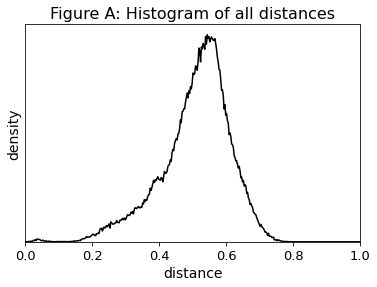

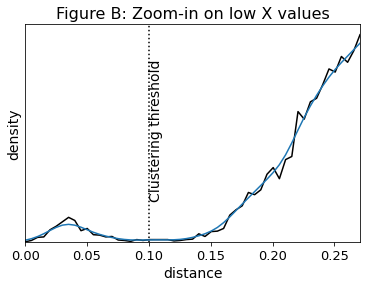

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot(xs, ys, title, xlabel, ylabel):
    figure = plt.figure()
    plt.plot(xs, ys, color='k')
    plt.tick_params(left=False, labelleft=False, labelsize=13)
    plt.ylim(0, plt.ylim()[1])
    plt.xlim(0, xs.max())
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    return figure

histogram = vamb.vambtools.read_npz('histogram.npz')
xs = np.linspace(0, 1, 400)
fig_a = plot(xs[1:], histogram, "Figure A: Histogram of all distances", 'distance', 'density')
hist2 = histogram[0:120:2] + histogram[1:120:2]
fig_b = plot(xs[0:110:2], hist2[:55], "Figure B: Zoom-in on low X values", 'distance', 'density')
densities = vamb.cluster._calc_densities(hist2, cuda=False)
plt.plot(xs[0:110:2], densities[:55])
threshold, success = vamb.cluster._find_threshold(densities, peak_valley_ratio=0.2, cuda=False)
plt.vlines(threshold, 0, plt.ylim()[1], linestyles='dotted')
plt.text(threshold, plt.ylim()[1]/5, "Clustering threshold", rotation=90, fontsize=14)

When picking an arbitrary contig as medoid (here contig 'S4C11236' in the CAMI2 toy human Airways short read dataset), and calculating the distances to all other contigs in the dataset, it follows a distribution as seen in Figure A. Unsurprisingly, the latent representation of most other contigs are mostly uncorrelated with the chosen contig, so the large majority of points are at a distance of around 0.5. No contigs have a larger distance than 0.8. 

But look at the lower left corner of Figure A: A small group of contigs appear to have a smaller distance to the medoid than most others - those of the cluster it belongs to. If the cluster is well-separated, this small initial peak should be mostly isolated from the main peak around 0.5 by a band of empty space, with a low density. Figure B confirms this is true.

Vamb groups the observed distances from the medoid M to a histogram similar to that in Figure B, and then iterates over the y-values of the histogram attempting to find first an initial peak, then a valley. At the bottom of the valley, the cutoff distance threshold is set, and all points closer to M than this point is clustered out. This threshold is depicted in Figure B by the dotted line. Vamb smoothes the histogram in order to mitigate the influence of random variation on the minima/maxima of the function. The smoothed hisotgram is visible in Figure B as a blue line.

The algorithm for detecting the threshold is as follows:

Parameter DEFAULT is 0.09 by default. RATIO is provided to the function and will be described later.

    Function `find_threshold` inputs = (medoid, RATIO), outputs = (threshold, was_successful)
    1. Calculate the distances from M to all other points. Group to histogram with bin size of 0.005 and smooth using a simple Gaussian kernel.
    2. If there are no other points within 0.03, return (0.025, None) end function
    3. Set success to FALSE. For X = 0 to X = 0.3:
        If the peak has not yet been declared over:
            If density is increasing:
                Set peak to X, peak density to density
                If X > 0.1, there is no initial peak near X=0, end loop
            Else if density < 0.6 * peak density
                Declare initial peak to be over
                Set minimum to density
        Else
            If density > 1.5 * minimum, we are entering another peak, end loop
            If density < minimum
                Set minimum to density
                if density < RATIO * peak density, we have successfully found a potential threshold
                    set success to TRUE
                    set threshold to X
                    
    4. If threshold is set to above 0.14 + 0.1 * RATIO: Initial peak is not close enough to X=0, set success to FALSE
    5. If success is FALSE and RATIO > 0.55: We do not accept failure. Set success to None and threshold to DEFAULT
    6. Return (threshold, success)
    
This function is annoyingly convoluted, but I was not able to find a simpler function that did not return nonsensical thresholds for a variety of different data points.

You will notice that the parameter RATIO controls how strict the criteria for accepting a threshold as successful is. If RATIO is low, say, 0.1, the initial peak must lie close to zero, and must be separated from the bulk of the other points with a deep valley. In constrast, a larger RATIO makes the criteria more relaxed. With a RATIO > 0.55, the function does not even accept failure, and will set the threshold to DEFAULT if no valley is found.

### Clustering

With the medoid search function and the threshold detection above, you can see how to begin clustering points. However, one more problem remains: Not all medoids separate the points to a neat small peak of close contigs and a larger one of far contigs as seen in Figure B. In fact, for the majority of medoids M sampled, the density is continuously increasing with distance, or the initial peak is too far away to consider M to be part of the peak, or there is clearly an initial double-peak rather than one. To make things worse, if a medoid M cannot successfully return a threshold, this does not mean M must be discarded - it is quite likely that M is contained in a cluster for which a threshold could be successfully found using another point as medoid.

To handle this problem, Vamb takes the approach of beginning with strict requirements for when a threshold is accepted, by setting the RATIO parameter low. If the threshold detection for a medoid returns failure, that medoid is simply skipped in the hope of finding another medoid with better results. Vamb then keeps count of how many of the recent attempts that yielded success - if too few did, RATIO is increased to relax the requirements for clusters.

The algorithm is as follows:

Parameters WINDOWSIZE and MINSUCCESSES is 200 and 15 by default, respectively. RATIO is initialized as 0.1

Function `cluster`
    1. Pick a medoid M using function `wander_medoid`
    2. Set threshold to None. While threshold is None:
           Set (success, threshold) to result of function `find_threshold(M, RATIO)`
           If fewer than MINSUCCESSES of last WINDOWSIZE attempts at finding threshold succeded:
               Increment RATIO by 0.1
               Discard the memory of the success or failure of previous attempts
    3. Output all points within threshold of M as a cluster. Remove these points from dataset
    4. If no more points remain, end function. Else, go to point 1.
    
Let's have a look at the actual Python function that does the clustering in Vamb:

In [21]:
# From Vamb 3.0, clustering is done by the ClusterGenerator object.
# We can use the old interface to construct a cluster iterator.
help(vamb.cluster.cluster)

Help on function cluster in module vamb.cluster:

cluster(matrix, labels=None, maxsteps=25, windowsize=200, minsuccesses=20, destroy=False, normalized=False, cuda=False)
    Create iterable of (medoid, {point1, point2 ...}) tuples for each cluster.
    
    Inputs:
        matrix: A (obs x features) Numpy matrix of data type numpy.float32
        labels: None or list of labels of points [None = range(len(matrix))]
        maxsteps: Stop searching for optimal medoid after N futile attempts [25]
        windowsize: Length of window to count successes [200]
        minsuccesses: Minimum acceptable number of successes [15]
        destroy: Save memory by destroying matrix while clustering [False]
        normalized: Matrix is already preprocessed [False]
        cuda: Accelerate clustering with GPU [False]
    
    Output: Generator of (medoid, {point1, point2 ...}) tuples for each cluster.



---
An explanation of a few of the parameters is in order:
    
`matrix` is the latent encoding.

`labels` is a list (or array) of labels for each point. If `None`, the labels will be the row position of the point in the matrix, e.g. the first point will be `0`.

`maxsteps`, `default`, `windowsize`, and `minsuccesses` correspond to the parameters described in the algorithms above. It's not realistic to expect users to set these - in other words, they should be OK as they are.

The function iteratively deletes the input matrix. To avoid this, the function works on a copy of the matrix. To skip copying the matrix and save memory, set `destroy` to `True`.

For clustering, the matrix needs to be preprocessed (as described above in the clustering algorithm). If this has already been done, set `normalized` to `True`. If `destroy` is `True`, the matrix will be normalized in-place.

If `cuda` is set to `True`, the clustering will be run on GPU for a significant speedup.

---
Depending on the size of the latent encoding, clustering can take quite some time. The heavy lifting here is done in PyTorch, so if you're not using a GPU, it might be worth making sure the BLAS library PyTorch is using is fast. The difference between a fast and a slow PyTorch implementation can be quite remarkable. If you use PyTorch v. >= 1.1 You can check it with `torch.__config__.show()` and notice if it says something about using Intel Math Kernel (MKL) library, or OpenBLAS. If it does, you're golden.

The generator will compute the clusters on-the-fly, meaning it will only compute the next cluster *once you ask for it*. Having the clustering return a generator gives a lot of flexibility:

You can manually iterate over the clusters:
    
    clusters = dict()
    for n, (medoid, cluster) in enumerate(vamb.cluster.cluster(latent)):
        clusters[medoid] = cluster
        
        if n + 1 == 1000: # Stop after 1000 clusters
            break

You can just put it directly in a dictionary:

    clusters = dict(vamb.cluster.cluster(latent))
    
Or you can use the `vamb.cluster.writeclusters` function to write the clusters to disk without storing them in memory:

    cluster_iterator = vamb.cluster.cluster(latent)
    with open('clusters.tsv', 'w') as clusterfile:
        vamb.cluster.writeclusters(clusterfile, cluster_iterator)
        
The `vamb.cluster.cluster` function is a thin wrapper which instantiates a `vamb.cluster.ClusterGenerator` object. This object yields `Cluster` objects. These objects contain various data, e.g. the `ClusterGenerator` contains the full state of the clusterer, and its internal parameters, whereas a `Cluster` contains all information about the cluster. If you just want the clusters and don't need access to these internal details, the simpler `vamb.cluster.cluster`, generator, yielding tuples, will be fine.

In this example, we will load it into a dictionary immediately:

In [47]:
# I cheat here and load in a latent representation that has trained for 500
# epochs instead of the shorter training we did above.
#latent = vamb.vambtools.read_npz('/Users/jakobnissen/Downloads/example/out/latent.npz')

# Notice we mask the contignames, since the dataloader could have filtered some contigs away
filtered_labels = [n for (n,m) in zip(contignames, mask) if m]
cluster_iterator = vamb.cluster.cluster(latent, labels=filtered_labels)
clusters = dict(cluster_iterator)

medoid, contigs = next(iter(clusters.items()))
print('First key:', medoid, '(of type:', type(medoid), ')')
print('Type of values:', type(contigs))
print('First element of value:', next(iter(contigs)), 'of type:', type(next(iter(contigs))))

First key: S4C262502 (of type: <class 'str'> )
Type of values: <class 'set'>
First element of value: S4C262502 of type: <class 'str'>


In [124]:
latent_semisupervised = np.load('/Users/nmb127/Documents/vamb/latent_trained_semisupervised.npy')
filtered_labels = [n for (n,m) in zip(contignames, mask) if m]
cluster_iterator = vamb.cluster.cluster(latent_semisupervised, labels=filtered_labels)
clusters = dict(cluster_iterator)

medoid, contigs = next(iter(clusters.items()))
print('First key:', medoid, '(of type:', type(medoid), ')')
print('Type of values:', type(contigs))
print('First element of value:', next(iter(contigs)), 'of type:', type(next(iter(contigs))))

lengthof = dict(zip(contignames, lengths))
filtered_bins = filterclusters(vamb.vambtools.binsplit(clusters, 'C'), lengthof)
print('Number of bins before splitting and filtering:', len(clusters))
print('Number of bins after splitting and filtering:', len(filtered_bins))

path = '/Users/nmb127/Documents/vamb_data/'
with open(f'{path}/clusters_semisupervised.tsv', 'w') as file:
    vamb.vambtools.write_clusters(file, filtered_bins)

First key: S10C346104 (of type: <class 'str'> )
Type of values: <class 'set'>
First element of value: S23C138088 of type: <class 'str'>
Number of bins before splitting and filtering: 2822
Number of bins after splitting and filtering: 651


In [109]:
latent_labels = np.load('/Users/nmb127/Documents/vamb/latent_trained_labels.npy')
filtered_labels = [n for (n,m) in zip(contignames, mask) if m]
cluster_iterator = vamb.cluster.cluster(latent_labels, labels=filtered_labels)
clusters = dict(cluster_iterator)

medoid, contigs = next(iter(clusters.items()))
print('First key:', medoid, '(of type:', type(medoid), ')')
print('Type of values:', type(contigs))
print('First element of value:', next(iter(contigs)), 'of type:', type(next(iter(contigs))))

lengthof = dict(zip(contignames, lengths))
filtered_bins = filterclusters(vamb.vambtools.binsplit(clusters, 'C'), lengthof)
print('Number of bins before splitting and filtering:', len(clusters))
print('Number of bins after splitting and filtering:', len(filtered_bins))

path = '/Users/nmb127/Documents/vamb_data/'
with open(f'{path}/clusters_labels.tsv', 'w') as file:
    vamb.vambtools.write_clusters(file, filtered_bins)

First key: S4C285569 (of type: <class 'str'> )
Type of values: <class 'set'>
First element of value: S27C271990 of type: <class 'str'>
Number of bins before splitting and filtering: 629
Number of bins after splitting and filtering: 716


<a id="postprocessing"></a>
## Postprocessing the clusters

We haven't written any dedicated postprocessing modules because how to postprocess really depends on what you're looking for in your data.

One of the greatest weaknesses of Vamb - probably of metagenomic binners in general - is that the bins tend to be highly fragmented. Unlike other binners, Vamb does not hide this fact, and will bin *all* input contigs. This means you'll have lots of tiny bins, some of which are legitimate (viruses, plasmids), but most are parts of larger genomes that didn't get binned properly - about 2/3 of the bins here, for example, are 1-contig bins. 

We're in the process of developing a tool for annotating, cleaning and merging bins based on phylogenetic analysis of the genes in the bins. That would be extremely helpful, but for now, we'll have to use more crude approaches.

First, we will split up all bins by their sample of origin using `vamb.vambtools.binsplit`. This will cause some bins to be fragmented, but for bins of high per-sample coverage, it will deduplicate them effectively. Second, we'll throw away all bins with less than 200,000 basepairs because we're only interested in genome-sized bins.

---

In [87]:
def filterclusters(clusters, lengthof):
    filtered_bins = dict()
    for medoid, contigs in clusters.items():
        binsize = sum(lengthof[contig] for contig in contigs)
    
        if binsize >= 200000:
            filtered_bins[medoid] = contigs
    
    return filtered_bins
        
lengthof = dict(zip(contignames, lengths))
filtered_bins = filterclusters(vamb.vambtools.binsplit(clusters, 'C'), lengthof)
print('Number of bins before splitting and filtering:', len(clusters))
print('Number of bins after splitting and filtering:', len(filtered_bins))

# Number of bins before splitting and filtering: 14036
# Number of bins after splitting and filtering: 415

Number of bins before splitting and filtering: 34985
Number of bins after splitting and filtering: 438


---
Even as we split some bins in 9, we're still left with fewer than half of the starting number of bins! Now, let's save the clusters to disk. For this we will use two writer functions:

1) `vamb.cluster.writeclusters`, that writes which clusters contains which contigs to a simple tab-separated file, and

2) `vamb.vambtools.writebins`, that writes FASTA files corresponding to each of the bins to a directory. This might be useful for some types of analysis you want to do down the road.

We will need to load all the contigs belonging to any bin into memory to use `vamb.vambtools.writebins`. If the contigs in your bins don't fit in memory, sorry, you gotta find another way to make those FASTA bins.

The cluster name when printing either way will be the dictionary key of the bins.

---

In [88]:
# This writes a .tsv file with the clusters and corresponding sequences
path = '/Users/nmb127/Documents/vamb_data/'
with open(f'{path}/clusters_semisupervised.tsv', 'w') as file:
    vamb.vambtools.write_clusters(file, filtered_bins)

# Only keep contigs in any filtered bin in memory
keptcontigs = set.union(*filtered_bins.values())

with open(f'{path}/data/airways/contigs.fna', 'rb') as file:
    fastadict = vamb.vambtools.loadfasta(file, keep=keptcontigs)
    
bindir = f'{path}/bins'
vamb.vambtools.write_bins(bindir, filtered_bins, fastadict, maxbins=500)

<a id="summary"></a>
## Summary of full workflow

This is the full default workflow from beginning to end. Calling Vamb from command line does essentially this, except with some input validation, logging, and saving intermediate results to files.

In [40]:
import sys
import os
sys.path.append('/Users/jakni/Documents/scripts/vamb')
import vamb

# Calculate TNF
with open('/Users/jakni/Downloads/example/contigs.fna', 'rb') as contigfile:
    tnfs, contignames, contiglengths = vamb.parsecontigs.read_contigs(contigfile)

# Calculate RPKM
bamdir = '/Users/jakni/Downloads/example/bamfiles/'
bampaths = [bamdir + filename for filename in os.listdir(bamdir) if filename.endswith('.bam')]
rpkms = vamb.parsebam.read_bamfiles(bampaths)

# Encode
vae = vamb.encode.VAE(nsamples=rpkms.shape[1])
dataloader, mask = vamb.encode.make_dataloader(rpkms, tnfs)
vae.trainmodel(dataloader)
latent = vae.encode(dataloader)

# Cluster and output clusters
filtered_labels = [n for (n,m) in zip(contignames, mask) if m]
cluster_iterator = vamb.cluster.cluster(latent, labels=filtered_labels)
with open('/Users/jakni/Downloads/example/bins.tsv', 'w') as binfile:
    vamb.cluster.write_clusters(binfile, cluster_iterator)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jakni/Downloads/example/contigs.fna'

In [11]:
latent.shape

(187685, 32)

In [19]:
import pandas as pd

df_tax = pd.read_csv(taxonomy_path, delimiter='\t', header=None)
df_ref = pd.read_csv(reference_path, delimiter='\t', header=None)

In [ ]:
df_tax[1][:1000]

In [58]:
labels

{'0': 'PC 1 (16.4%)',
 '1': 'PC 2 (9.9%)',
 '2': 'PC 3 (8.9%)',
 '3': 'PC 4 (7.2%)',
 '4': 'PC 5 (6.0%)',
 '5': 'PC 6 (5.4%)',
 '6': 'PC 7 (4.5%)',
 '7': 'PC 8 (4.4%)',
 '8': 'PC 9 (3.8%)',
 '9': 'PC 10 (3.7%)',
 '10': 'PC 11 (3.3%)',
 '11': 'PC 12 (3.1%)',
 '12': 'PC 13 (2.6%)',
 '13': 'PC 14 (2.5%)',
 '14': 'PC 15 (2.4%)',
 '15': 'PC 16 (2.3%)',
 '16': 'PC 17 (2.0%)',
 '17': 'PC 18 (1.8%)',
 '18': 'PC 19 (1.4%)',
 '19': 'PC 20 (1.3%)',
 '20': 'PC 21 (1.3%)',
 '21': 'PC 22 (1.1%)',
 '22': 'PC 23 (0.9%)',
 '23': 'PC 24 (0.9%)',
 '24': 'PC 25 (0.8%)',
 '25': 'PC 26 (0.7%)',
 '26': 'PC 27 (0.5%)',
 '27': 'PC 28 (0.4%)',
 '28': 'PC 29 (0.3%)',
 '29': 'PC 30 (0.1%)',
 '30': 'PC 31 (0.1%)',
 '31': 'PC 32 (0.0%)'}

In [20]:
df_ref

,0,1,2,3,4
0,S23C236194,OTU_97.38699.0,CP013953.1,405835,408637
1,S23C27593,OTU_97.44406.0,CP015430.1,1591817,1594726
2,S23C53437,OTU_97.35057.0,CP012974.1,260542,266700
3,S23C191539,OTU_97.16597.0,CP010116.1,1675948,1678686
4,S23C111210,OTU_97.20680.0,CP013619.1,408162,411064
...,...,...,...,...,...
187680,S10C452544,OTU_97.11086.0,CP015831.1,849612,854660
187681,S10C406459,OTU_97.36530.0,CP012013.1,2217103,2221049
187682,S10C287317,OTU_97.34832.0,CP001781.1,959338,962517
187683,S10C136350,OTU_97.35501.0,CP014022.1,2434269,2437523


In [18]:
df_tax

,0,1,2
0,OTU_97.39766.0,Corynebacterium pseudotuberculosis,Corynebacterium
1,OTU_97.7195.0,Acinetobacter baumannii,Acinetobacter
2,OTU_97.34725.0,Staphylococcus aureus,Staphylococcus
3,OTU_97.1051.0,Corynebacterium ulcerans,Corynebacterium
4,OTU_97.34663.0,Staphylococcus aureus,Staphylococcus
...,...,...,...
823,OTU_97.7235.0,Staphylococcus aureus,Staphylococcus
824,OTU_97.34920.0,Streptococcus pseudopneumoniae,Streptococcus
825,OTU_97.23486.0,Flavobacterium crassostreae,Flavobacterium
826,OTU_97.11609.1,Tistrella mobilis,Tistrella


In [5]:
df_ref

,0,1,2,3,4
0,S23C236194,OTU_97.38699.0,CP013953.1,405835,408637
1,S23C27593,OTU_97.44406.0,CP015430.1,1591817,1594726
2,S23C53437,OTU_97.35057.0,CP012974.1,260542,266700
3,S23C191539,OTU_97.16597.0,CP010116.1,1675948,1678686
4,S23C111210,OTU_97.20680.0,CP013619.1,408162,411064
...,...,...,...,...,...
187680,S10C452544,OTU_97.11086.0,CP015831.1,849612,854660
187681,S10C406459,OTU_97.36530.0,CP012013.1,2217103,2221049
187682,S10C287317,OTU_97.34832.0,CP001781.1,959338,962517
187683,S10C136350,OTU_97.35501.0,CP014022.1,2434269,2437523


In [47]:
df_ref[1].astype(str)

0         OTU_97.38699.0
1         OTU_97.44406.0
2         OTU_97.35057.0
3         OTU_97.16597.0
4         OTU_97.20680.0
               ...      
187680    OTU_97.11086.0
187681    OTU_97.36530.0
187682    OTU_97.34832.0
187683    OTU_97.35501.0
187684    OTU_97.24948.0
Name: 1, Length: 187685, dtype: object

In [9]:
latent.shape

(187685, 32)

In [30]:
df_ref[1].value_counts()

OTU_97.36530.0    3296
OTU_97.34832.0    3028
OTU_97.34830.0    2290
OTU_97.35048.0    2175
OTU_97.37297.1    2148
                  ... 
OTU_97.9699.0        1
OTU_97.28993.0       1
OTU_97.42441.1       1
OTU_97.151.0         1
OTU_97.9566.0        1
Name: 1, Length: 639, dtype: int64

In [31]:
five_clusters = ['OTU_97.36530.0', 'OTU_97.34832.0', 'OTU_97.34830.0', 'OTU_97.35048.0', 'OTU_97.37297.1']

In [24]:
classes_dict = {r[0]: r[1] for i, r in df_ref.iterrows()}

In [32]:
classes_order = np.array([classes_dict[c] for c in contignames])

In [34]:
mask = np.argwhere(np.isin(classes_order, five_clusters)).ravel()

In [36]:
mask

array([    16,     63,     70, ..., 187672, 187674, 187678])

In [38]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA


# df_tax = pd.read_csv(taxonomy_path, delimiter='\t', header=None)

reference_path = '/Users/nmb127/Documents/vamb_data/data/airways/reference.tsv'
df_ref = pd.read_csv(reference_path, delimiter='\t', header=None)

latent = np.load('/Users/nmb127/Documents/vamb/latent_trained.npy')

pca = PCA()
components = pca.fit_transform(latent[mask])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(3),
    color=classes_order[mask],
)
fig.update_traces(diagonal_visible=False)
fig.show()

<a id="memory"></a>
## Running VAMB with low memory (RAM)

In the VAMB software, a series of tradeoffs can be taken to decrease RAM consumption, usually to the detriment of some other property like speed or convenience (though not accuracy). With all of those tradeoffs taken, VAMB is relatively memory efficient. By default, several of these tradeoffs are are not taken when running from a Python interpreter, however they are all enabled when running VAMB from command line.

The memory consumption of the encoding step is usually the bottleneck. With all memory-saving options enabled, this uses approximately $4 * N_{contigs}*(103+N_{latent}+N_{samples})$ bytes, plus some hundreds of megabytes of overhead. As a rule of thumb, if you don't have at least two times that amount of memory, you might want to enable some or all of these memory optimizations.

Here's a short list of all the available memory saving options:

- Pass a path to the `dumpdirectory` in the `vamb.parsecontigs.read_bamfiles` function. Temporary files will be written to files in this directory to avoid keeping them in memory. This takes a little bit of disk space, but saves lots of RAM
- In the `encode.make_dataloader` function, set `destroy` to True. This will in-place modify your RPKM and TNF array, deleting unusable rows and normalizing them. This prevents the creation of a copy of the data.
- Similarly, set `destroy=True` when using the `cluster.cluster` function. Again, the input (latent) datasets are modified in-place, saving a copy of the data. This function will completely consume the input array.
- When clustering, instead of generating clusters in memory, instantiate the cluster iterator and pass it directly to `cluster.write_clusters`. This way, each cluster will be written to disk after creation and not accumulate in memory. This obviously requires disk space, and you will have to reload the clusters if you are planning on using them.

<a id="benchmark"></a>
## Optional: Benchmarking your bins

If you want to tweak or enchance Vamb, you'll want to know how well it performs. For this to make any sense, you need to have a *reference*, that is, a list of bins that are deemed true and complete. Otherwise, what do you benchmark against?

Vamb's benchmarking works in the following way: You count the number of genomes for which *any* bin has a competeness (recall) above a certain level and a contamination below a certain level (i.e. precision above a certain level). Recall and precision are calculated by the number of basepairs with >= 1x coverage in the right genome versus wrong genomes. In other words, for a bin B and a genome G, the recall is (# basepairs of G covered by a contig in B) / (# basepairs of G covered by any contig), and precision is (# basepairs of G covered by a contig in B) / (# basepairs of any genome covered by a contig in B). An bin *can* count towards multiple genomes given a low enough precision threshold.

Let's go through how to benchmark your bins.

---
#### Genome reference file
First, you need a proper reference. For each contig (or sequence) you are binning, you need to provide:
* The name of the contig
* The name of the genome the contig is coming from (genome names may be arbitrarily chosen)
* The name of the reference contig from that genome (may also be arbitrarily chosen)
* The leftmost position (start) of where the contig aligns to the reference contig
* The rightmost position (end) of where the contig aligns to the reference contig.

This information is given as a tab-separated file, with one line per contig. For example, suppose that I have a contig `test_contig_45` which I have located to belong to position 113501 to position 132884 in the reference contig `NC_013740.1` of the genome of `Acidaminococcus fermentans`. Then, one of the lines in the reference file will be:

    test_contig_45     Acidaminococcus fermentans       NC_013740.1    113501     132884

This file can then be loaded into a `Reference` object:
    
    with open('/path/to/ref_file.tsv') as ref_file:
        reference = Reference.from_file(ref_file)
        
#### Reference taxonomy file
One can choose to benchmark at different taxonomic levels: A bin that is completely uncontaminated on the genus level may not be pure species-wise. Vamb allows you to benchmark at arbitrary taxonomic levels.

The reference file described above is taken to represent the lowest (i.e. most specific) taxonomic level. In the taxonomy file, each genome of the reference file is then assigned to one higher rank. Different genomes may be assigned to the same higher rank, but each genome can only be assigned to one. These higher ranks may then be assigned yet higher ranks, and so on. For example's sake, let us assume the lowest "Genome" level in the genome reference file represents strains, and the higher ranks are species, genera and families, in order.

In the reference file, this is written as a tab-separated text file with one line per genome, and one column per taxonomic level. Note that the leftmost column is taken to be genome names given in the genome reference file. So, for the example line above of the genome reference file, if a reference taxonomy file is loaded, there *must* be a line where the leftmost column is `Acidaminococcus fermentans`. If the true species/genus/whatever of a genome is unknown, you can assign it to an arbitrarily named species/genus. For example, a reference taxnomy file may begin with the following four lines - note that `Strain_118` is assigned an arbitrary species, genus and family.

    Strain_455         Bacillus subtilis         Bacillus           Bacillaceae
    Strain_255         Bacillus licheniformis    Bacillus           Bacillaceae
    Strain_1067        Clostridium tetani        Clostridium        Clostridiaceae
    Strain_118         Strain_118                Strain_118         Strain_118
    
The definitions given above for *recall* and *precision* only makes sense given known mapping locations for contigs, which are specified in the genome reference file. However, the mapping location of a contig to e.g. a genus is a nonsensical concept. So, how is recall and preicison defined for higher taxonomic levels defined?

The recall of a higher taxonomic level is the maximum of all of its members. The precision of a higher taxonomic level is the sum of all of its members.

A reference taxonomy file can be added to a `Reference` object like so:

    with open('/path/to/tax_file.tsv') as tax_file:
        reference.load_tax_file(tax_file)

Then you need to load your observed bins. The format of this file is expected to be the same as the output of Vamb, namely a two-column file, with arbitrary bin names in the first column and contig names in the second column. Any contig seen in the observed bins is expected to be present in the reference as well. You also need to provide the reference:

    with open('/path/to/clusters.tsv') as clusters_file:
        bins = Binning.from_file(clusters_file, reference)
        
You can the query the bins for information about the quality of your bins. Below I'll show an example of this in practice: I will use Vamb's (default) performance on the `metabat_errorfree` dataset and compare it to that of MetaBAT2.

In [51]:
# First load in the Reference
# reference_path = '/Users/jakobnissen/Downloads/vambdata/metahit/reference.tsv'
reference_path = '/Users/nmb127/Documents/vamb_data/data/airways/reference.tsv'

!head $reference_path # show first 10 lines of reference file

with open(reference_path) as reference_file:
    reference = vamb.benchmark.Reference.from_file(reference_file)

S23C236194	OTU_97.38699.0	CP013953.1	405835	408637
S23C27593	OTU_97.44406.0	CP015430.1	1591817	1594726
S23C53437	OTU_97.35057.0	CP012974.1	260542	266700
S23C191539	OTU_97.16597.0	CP010116.1	1675948	1678686
S23C111210	OTU_97.20680.0	CP013619.1	408162	411064
S23C216129	OTU_97.409.0	CP013957.1	103779	106015
S23C2782	OTU_97.45246.0	CP007573.1	1941619	1956892
S23C9729	OTU_97.44851.0	CP015426.1	1099587	1121671
S23C36165	OTU_97.409.0	CP013957.1	427732	429801
S23C90379	OTU_97.2104.0	CP019196.1	300725	303071


---
The first 10 lines wrap, but you can see the information expected to be present.

The `reference` object contains a bunch of attributes which keeps track of which contigs belongs to which bins. You can see which ones using good ol' `help`:

`>>> help(reference)`

    class Reference(builtins.object)
     |  Reference(genomes, taxmaps=[])
     |  
     |  A set of Genomes known to represent the ground truth for binning.
     |  Instantiate with any iterable of Genomes.
     |  
     |  >>> print(my_genomes)
     |  [Genome('E. coli'), ncontigs=95, breadth=5012521),
     |   Genome('Y. pestis'), ncontigs=5, breadth=46588721)]
     |  >>> Reference(my_genomes)
     |  Reference(ngenomes=2, ncontigs=100)
     |  
     |  Properties:
     |  self.genomes: {genome_name: genome} dict
     |  self.contigs: {contig_name: contig} dict
     |  self.genomeof: {contig: genome} dict
     |  self.breadth: Total length of all genomes
     |  self.ngenomes
     |  self.ncontigs

        [ ... ]
    
Now, I can load in the taxonomy file:

---

In [52]:
taxonomy_path = '/Users/nmb127/Documents/vamb_data/data/airways/taxonomy.tsv'

!head $taxonomy_path # show first 10 lines of reference file

with open(taxonomy_path) as taxonomy_file:
    reference.load_tax_file(taxonomy_file)

OTU_97.39766.0	Corynebacterium pseudotuberculosis	Corynebacterium
OTU_97.7195.0	Acinetobacter baumannii	Acinetobacter
OTU_97.34725.0	Staphylococcus aureus	Staphylococcus
OTU_97.1051.0	Corynebacterium ulcerans	Corynebacterium
OTU_97.34663.0	Staphylococcus aureus	Staphylococcus
OTU_97.8581.0	Corynebacterium doosanense	Corynebacterium
OTU_97.8702.0	Flavobacterium psychrophilum	Flavobacterium
OTU_97.31374.1	Corynebacterium ulcerans	Corynebacterium
OTU_97.479.0	Flavobacterium gilvum	Flavobacterium
OTU_97.37290.0	Staphylococcus equorum	Staphylococcus


---
Now. we may load the binning itself. I'll automatically filter all bins smaller than 200,000 basepairs away:

In [47]:
reference

Reference(ngenomes=639, ncontigs=187685, ranks=3)

In [30]:
reference.contigs

{'S23C205634': Contig(S23C205634, subject=CP013953.1, 2821996:2824045),
 'S23C123555': Contig(S23C123555, subject=CP013953.1, 2128622:2130698),
 'S8C270152': Contig(S8C270152, subject=CP013953.1, 2693717:2696030),
 'S11C26119': Contig(S11C26119, subject=CP013953.1, 2682163:2691787),
 'S8C256117': Contig(S8C256117, subject=CP013953.1, 2280529:2283567),
 'S8C265678': Contig(S8C265678, subject=CP013953.1, 2423042:2425076),
 'S23C103369': Contig(S23C103369, subject=CP013953.1, 2160299:2162331),
 'S8C169845': Contig(S8C169845, subject=CP013953.1, 1250347:1253646),
 'S8C210620': Contig(S8C210620, subject=CP013953.1, 2797398:2799470),
 'S8C54508': Contig(S8C54508, subject=CP013953.1, 2392881:2394908),
 'S12C249689': Contig(S12C249689, subject=CP013953.1, 2005224:2007265),
 'S11C9732': Contig(S11C9732, subject=CP013953.1, 236522:245329),
 'S11C2002': Contig(S11C2002, subject=CP013953.1, 1790161:1802980),
 'S11C11089': Contig(S11C11089, subject=CP013953.1, 1598732:1607409),
 'S11C25125': Contig

In [125]:
path = '/Users/nmb127/Documents/vamb_data/'
filename = f'{path}/clusters.tsv'
filename2 = f'{path}/clusters_semisupervised.tsv'
filename3 = f'{path}/clusters_labels.tsv'

with open(filename) as clusters_file:
    vamb_clusters = vamb.vambtools.read_clusters(clusters_file)
    vamb_clusters_clean = {k: [i.strip() for i in v] for k, v in vamb_clusters.items()}
    vamb_bins = vamb.benchmark.Binning(vamb_clusters_clean, reference, minsize=200000)
    
with open(filename2) as clusters_file:
    metabat_clusters = vamb.vambtools.read_clusters(clusters_file)
    metabat_clusters_clean = {k: [i.strip() for i in v] for k, v in metabat_clusters.items()}
    metabat_bins = vamb.benchmark.Binning(metabat_clusters_clean, reference, minsize=200000)
    
with open(filename3) as clusters_file:
    labels_clusters = vamb.vambtools.read_clusters(clusters_file)
    labels_clusters_clean = {k: [i.strip() for i in v] for k, v in labels_clusters.items()}
    labels_bins = vamb.benchmark.Binning(labels_clusters_clean, reference, minsize=200000)

In [108]:
reference

Reference(ngenomes=639, ncontigs=187685, ranks=3)

In [101]:
len(vamb_clusters), len(metabat_clusters)

(427, 438)

In [102]:
vamb_bins

Binning(91922/187685 contigs, ReferenceID=0x7fd33a925670)

In [103]:
metabat_bins

Binning(93324/187685 contigs, ReferenceID=0x7fd33a925670)

In [64]:
len(reference.genomes)

639

In [72]:
len(classes_order), len(set(classes_order))

(187685, 639)

In [77]:
len(labels_int), len(set(labels_int))

(187685, 639)

In [82]:
import torch
import torch.nn.functional as F

labels_int = np.unique(classes_order, return_inverse=True)[1]
ont_hot_labels = F.one_hot(torch.as_tensor(labels_int))

In [84]:
ont_hot_labels.shape

torch.Size([187685, 639])

In [67]:
len(vamb_clusters_clean)

427

In [68]:
len(vamb_clusters_clean) / 639.0

0.6682316118935837

---
The Binning object keeps track of your bins and how they relate to the `Reference`:

    help(vamb_bins)
    
    class Binning(builtins.object)
     |  Binning(contigsof, reference, recalls=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99], precisions=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99], checkpresence=True, disjoint=True, binsplit_separator=None, minsize=None, mincontigs=None)
     |  
     |  The result of a set of clusters applied to a Reference.
     |  >>> ref
     |  (Reference(ngenomes=2, ncontigs=5)
     |  >>> b = Binning({'bin1': {contig1, contig2}, 'bin2': {contig3, contig4}}, ref)
     |  Binning(4/5 contigs, ReferenceID=0x7fe908180be0)
     |  >>> b[0.5, 0.9] # num. genomes 0.5 recall, 0.9 precision
     |  1
     |  
     |  Init arguments:
     |  ----------- Required ---------
     |  contigsof:     Dict of clusters, each sequence present in the Reference
     |  reference:     Associated Reference object
     |  ----------- Optional ---------
     |  recalls:       Iterable of minimum recall thresholds
     |  precisions:    Iterable of minimum precision thresholds
     |  checkpresence: Whether to raise an error if a sequence if not present in Reference
     |  disjoint:      Whether to raise an error if a sequence is in multiple bins
     |  binsplit_separator: Split bins according to prefix before this separator in seq name
     |  minsize:       Minimum sum of sequence lengths in a bin to not be ignored
     |  mincontigs:    Minimum number of sequence in a bin to not be ignored
     |  
     |  Properties:
     |  self.reference:       Reference object of this benchmark
     |  self.recalls:         Sorted tuple of recall thresholds
     |  self.precisions:      Sorted tuple of precision thresholds
     |  self.nbins:           Number of bins
     |  self.ncontigs:        Number of binned contigs
     |  self.contigsof:       {bin_name: {contig set}}
     |  self.binof:           {contig: bin_name(s)}, val is str or set
     |  self.breadthof:       {bin_name: breadth}
     |  self.intersectionsof: {genome: {bin:_name: intersection}}
     |  self.breadth:         Total breadth of all bins
     |  self.counters:        List of (rec, prec) Counters of genomes for each taxonomic rank
     |  
     |  Methods defined here:
     
     [ ... ]

---
The easiest way to get information about the quality of a `Binning` is by using the `summary` method. This prints the number of genomes reconstructed for each taxonomic level for each recall threshold at a precision threshold of 0.9:

---

In [104]:
print('Vamb bins:')
for rank in vamb_bins.summary():
    print('\t'.join(map(str, rank)))
print('\nMETABAT2 bins:')
for rank in metabat_bins.summary():
    print('\t'.join(map(str, rank)))

Vamb bins:
118	113	109	108	101	93	57	38	21
104	100	96	95	90	82	52	35	20
55	52	50	50	47	44	30	17	8

METABAT2 bins:
116	112	106	102	97	89	58	38	23
100	99	95	91	86	80	53	34	21
51	51	48	48	44	40	28	14	8


---
On the [metabat webpage](https://bitbucket.org/berkeleylab/metabat/wiki/CAMI) they have a neat plot where they plot the number of observed bins at different recalls for a specific specificity. Just for fun, let's recreate that here with our data, using the species level.

---

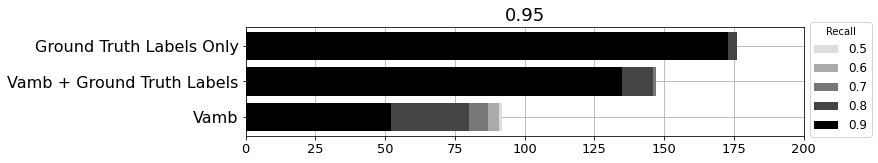

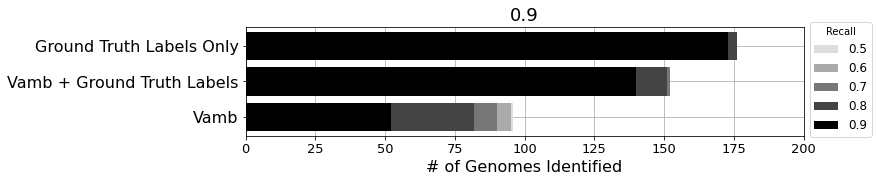

In [126]:
import matplotlib.pyplot as plt
%matplotlib inline

for precision in 0.95, 0.9:
    plt.figure(figsize=(10, 2))
    colors = ['#DDDDDD', '#AAAAAA', '#777777', '#444444', '#000000']
    recalls = [0.5, 0.6, 0.7, 0.8, 0.9]
    for y, bins in zip((0, 1, 2), (vamb_bins, metabat_bins, labels_bins)):
        for color, recall in zip(colors, recalls):
            plt.barh(y, bins.counters[1][(recall, precision)], color=color)

    plt.title(str(precision), fontsize=18)
    plt.yticks([0, 1, 2], ['Vamb', 'Vamb + Ground Truth Labels', 'Ground Truth Labels Only'], fontsize=16)
    plt.xticks([i*25 for i in range(9)], fontsize=13)
    plt.legend([str(i) for i in recalls], bbox_to_anchor=(1, 1.1), title='Recall', fontsize=12)
    
    if precision == 0.9:
        plt.xlabel('# of Genomes Identified', fontsize=16)
    plt.gca().set_axisbelow(True)
    plt.grid()